In [15]:
from campa.tl import Experiment, FeatureExtractor
import os
from campa.pl import plot_mean_intensity, zscore, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change
from campa.pl import plot_co_occurrence, plot_co_occurrence_grid
import anndata as ad
from campa.utils import init_logging
import numpy as np
import logging
init_logging(level=logging.WARNING)

In [3]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')

In [7]:
extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', exp.data_params['data_dirs'][0], 'features_annotation.h5ad'))



In [9]:
extr.mpp_data

In [64]:
from skimage.measure import label, regionprops
import pandas as pd

def extract_object_stats(self, area_threshold=0):
    """
    Extract number and area of connected components per cluster for each cell.

    Adds obsm object_area_mean, object_area_std, object_count, object_S1, object_S2, with

    object_S1 = sum(area) 
    object_S2 = sum(area**2)

    object_area_mean = object_S1 / object_count
    object_area_std = sqrt(object_S2/object_count - (object_S1/object_count)**2)

    Args:
        area_threshold: all components smaller than this threshold are discarded
    """
    if self.adata is None:
        self.log.info('extract_object_stats: adata is None. Calculate it with extract_intensity_size before extracting object stats. Exiting.')
        return
    self.log.info(f"calculating object stats with area threshold {area_threshold} for clustering {self.params['cluster_name']} (col: {self.params['cluster_col']})")
    cluster_names = {n: i for i,n in enumerate(self.clusters + [''])}
    
    counts = []
    S1 = []
    S2 = []
    obj_ids = []
    for obj_id in self.mpp_data.unique_obj_ids[:10]:
        mpp_data = self.mpp_data.subset(obj_ids=[obj_id], copy=True)
        img, (pad_x, pad_y) = mpp_data.get_object_img(obj_id, data=self.params['cluster_name'], annotation_kwargs={'annotation': self.annotation, 'to_col': self.params['cluster_col']})
        # convert labels to numbers
        img = np.vectorize(cluster_names.__getitem__)(img)
        label_img = label(img, background=len(self.clusters))

        # iterate over all regions in this image
        obj_counts = np.zeros(len(self.clusters))
        obj_S1 = np.zeros(len(self.clusters))
        obj_S2 = np.zeros(len(self.clusters))
        for region in regionprops(label_img, intensity_image=img):
            if region.area > area_threshold:
                assert region.min_intensity == region.max_intensity
                obj_counts[region.min_intensity] += 1
                obj_S1[region.min_intensity] += region.area
                obj_S2[region.min_intensity] += region.area**2
        counts.append(obj_counts)
        S1.append(obj_S1)
        S2.append(obj_S2)
        obj_ids.append(obj_id)

    # save to adata
    for res, name in zip([counts, S1, S2], ['object_count', 'object_S1', 'object_S2']):
        df = pd.DataFrame(np.array(res), index=obj_ids, columns=self.clusters)
        df.index = df.index.astype(str)
        # ensure obj_ids are in correct order
        df = pd.merge(df, self.adata.obs, how='right', left_index=True, right_on='mapobject_id', suffixes=('','right'))[df.columns]
        df = df.fillna(0)
        # add to adata.obsm
        self.adata.obsm[name] = df
    # add mean and std of object size
    self.adata.obsm['object_size_mean'] = self.adata.obsm['object_S1']/self.adata.obsm['object_count']
    self.adata.obsm['object_size_std'] = np.sqrt(self.adata.obsm['object_S2'] / self.adata.obsm['object_count'] - self.adata.obsm['object_size_mean']**2)
    self.adata.uns['object_stats_params'] = {'area_threshold': area_threshold}
    # write adata
    #self.adata.write(self.fname)

In [65]:
extract_object_stats(extr, area_threshold=20)

In [66]:
extr.adata

AnnData object with n_obs × n_vars = 557 × 34
    obs: 'mapobject_id', 'plate_name', 'well_name', 'well_pos_y', 'well_pos_x', 'tpoint', 'zplane', 'label', 'is_border', 'mapobject_id_cell', 'plate_name_cell', 'well_name_cell', 'well_pos_y_cell', 'well_pos_x_cell', 'tpoint_cell', 'zplane_cell', 'label_cell', 'is_border_cell', 'is_mitotic', 'is_mitotic_labels', 'is_polynuclei_HeLa', 'is_polynuclei_HeLa_labels', 'is_polynuclei_184A1', 'is_polynuclei_184A1_labels', 'is_SBF2_Sphase_labels', 'is_SBF2_Sphase', 'Heatmap-48', 'cell_cycle', 'description', 'dimensions', 'id', 'cell_type', 'EU', 'duration', 'perturbation', 'secondary_only', 'siRNA', 'perturbation_duration', 'LocalDensity_Nuclei_800', 'TR_factor', 'TR_norm', 'TR', 'TR_factor_DMSO-unperturbed', 'TR_norm_DMSO-unperturbed', 'obj_id_int'
    uns: 'clusters', 'params', 'object_stats_params'
    obsm: 'size', 'object_count', 'object_S1', 'object_S2', 'object_size_mean', 'object_size_std'
    layers: 'intensity_Cajal bodies', 'intensity_Ex

In [57]:
import pandas as pd
for res, name in zip([counts, S1, S2], ['object_count', 'object_S1', 'object_S2']):
    df = pd.DataFrame(np.array(res), index=obj_ids, columns=self.clusters)
    df.index = df.index.astype(str)
    # ensure obj_ids are in correct order
    df = pd.merge(df, self.adata.obs, how='right', left_index=True, right_on='mapobject_id', suffixes=('','right'))[df.columns]
    df = df.fillna(0)
    # add to adata.obsm
    self.adata.obsm[name] = df
# add mean and std of object size
self.adata.obsm['object_size_mean'] = self.adata.obsm['object_S1']/self.adata.obsm['object_count']
self.adata.obsm['object_size_std'] = np.sqrt(self.adata.obsm['object_S2'] / self.adata.obsm['object_count'] - self.adata.obsm['object_size_mean']**2)


In [63]:
self.adata.obsm['object_size_std']

,Cajal bodies,Extra-nuclear,Nuclear periphery,Nuclear speckles,Nucleolus,Nucleoplasm,PML bodies
0,NaN,499.000000,30.371039,107.852036,617.946240,0.0,35.384783
1,NaN,436.500000,35.036489,NaN,67.500000,0.0,9.299044
2,NaN,194.904489,63.842306,58.228939,134.000000,0.0,19.422210
3,NaN,571.426286,8.041559,76.678140,150.493263,2930.5,29.450523
4,NaN,365.842711,100.636412,88.951176,564.449191,0.0,18.431019
...,...,...,...,...,...,...,...
552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
obj_id = self.mpp_data.unique_obj_ids[0]

In [14]:
mpp_data = self.mpp_data.subset(obj_ids=[obj_id], copy=True)

In [23]:
cluster_names = {n: i for i,n in enumerate(self.clusters + [''])}
img, (pad_x, pad_y) = mpp_data.get_object_img(obj_id, data=self.params['cluster_name'], annotation_kwargs={'annotation': self.annotation, 'to_col': self.params['cluster_col']})
# convert labels to numbers
img = np.vectorize(cluster_names.__getitem__)(img)

In [26]:
res = label(img, background=len(self.clusters))

In [32]:
props = regionprops(res, intensity_image=img)

In [42]:
counts = np.zeros(len(self.clusters))
S1 = np.zeros(len(self.clusters))
S2 = np.zeros(len(self.clusters))

for region in props:
    if region.area > 20:
        assert region.min_intensity == region.max_intensity
        counts[region.min_intensity] += 1
        S1[region.min_intensity] += region.area
        S2[region.min_intensity] += region.area**2


In [43]:
print(self.clusters)
print(counts)
print('mean area: ', S1/counts)
print('stdev: ', np.sqrt(S2/counts - (S1/counts)**2))

['Cajal bodies', 'Extra-nuclear', 'Nuclear periphery', 'Nuclear speckles', 'Nucleolus', 'Nucleoplasm', 'PML bodies']
[ 0.  2.  5. 18.  3.  1. 13.]
mean area:  [          nan  547.           64.          125.22222222 1040.66666667
 8287.           83.38461538]
stdev:  [         nan 499.          30.37103884 107.85203627 617.94624002
   0.          35.38478261]


/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_95245/641664394.py:3: RuntimeWarning: invalid value encountered in true_divide
  print('mean area: ', S1/counts)
/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_95245/641664394.py:4: RuntimeWarning: invalid value encountered in true_divide
  print('stdev: ', np.sqrt(S2/counts - (S1/counts)**2))


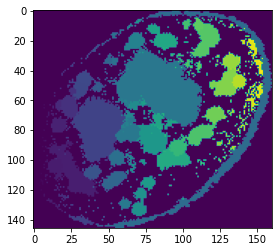

In [29]:
plt.imshow(res)

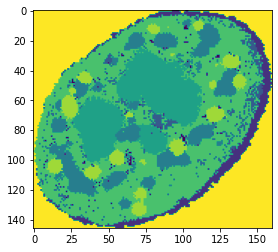

In [18]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
# object_size_mean
# object_size_std
# object_S1
# object_S2
# object_count

In [45]:
extr.adata.obsm['size']

,all,Cajal bodies,Extra-nuclear,Nuclear periphery,Nuclear speckles,Nucleolus,Nucleoplasm,PML bodies
0,17008,171,1210,672,2352.0,3135,8344,1124
1,6936,44,1114,302,51.0,595,4603,227
2,11337,246,738,710,887.0,2075,6164,517
3,11693,70,1531,300,1280.0,2028,5951,533
4,15853,381,959,1138,2257.0,3026,7364,728
...,...,...,...,...,...,...,...,...
552,14497,115,1518,1958,1003.0,2702,6731,470
553,11101,95,854,1245,1019.0,2071,5249,568
554,10054,98,1152,1503,892.0,1607,4350,452
555,17130,87,1188,492,1592.0,2993,9988,790
